# Siamese

Source: https://keras.io/examples/mnist_siamese/

In [1]:
import numpy as np

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

In [2]:
NUM_CLASSES = 10
EPOCHS = 20
BATCH_SIZE = 128

In [3]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(NUM_CLASSES)]) - 1
    for d in range(NUM_CLASSES):
        for i in range(n):
            # similar pair
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, NUM_CLASSES)
            # dissimilar pair
            dn = (d + inc) % NUM_CLASSES
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [4]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]
print(f"Input images shape {input_shape}")


# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(NUM_CLASSES)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)
tr_y = tf.cast(tr_y, dtype=tf.float32)


digit_indices = [np.where(y_test == i)[0] for i in range(NUM_CLASSES)]
te_pairs, te_y = create_pairs(x_test, digit_indices)
te_y = tf.cast(te_y, dtype=tf.float32)


# network definition
base_network = create_base_network(input_shape)


input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)



# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)



distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])


model = Model([input_a, input_b], distance)


# train
rms = RMSprop()


model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])


model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print(f'* Accuracy on training set: {(100 * tr_acc):.2f}')
print(f'* Accuracy on test set: {(100 * te_acc):.2f}')

Input images shape (28, 28)
Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 8s 71us/sample - loss: 0.0956 - accuracy: 0.8873 - val_loss: 0.0434 - val_accuracy: 0.9567
Epoch 2/20
108400/108400 [==============================] - 6s 60us/sample - loss: 0.0399 - accuracy: 0.9626 - val_loss: 0.0296 - val_accuracy: 0.9688
Epoch 3/20
108400/108400 [==============================] - 7s 61us/sample - loss: 0.0277 - accuracy: 0.9730 - val_loss: 0.0279 - val_accuracy: 0.9693
Epoch 4/20
108400/108400 [==============================] - 7s 62us/sample - loss: 0.0222 - accuracy: 0.9780 - val_loss: 0.0273 - val_accuracy: 0.9681
Epoch 5/20
108400/108400 [==============================] - 7s 60us/sample - loss: 0.0184 - accuracy: 0.9813 - val_loss: 0.0238 - val_accuracy: 0.9725
Epoch 6/20
108400/108400 [==============================] - 7s 61us/sample - loss: 0.0161 - accuracy: 0.9839 - val_loss: 0.0243 - val_accuracy: 0.9717
Epoch 7/20
1084

In [5]:
num_images_per_class = int(tr_pairs[:, 0].shape[0]/10 - 1)
num_images_per_class

10839

In [6]:
import matplotlib.pyplot as plt

plt.imshow(tr_pairs[num_images_per_class-3, 0])

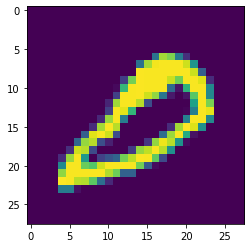

In [7]:
plt.imshow(tr_pairs[num_images_per_class-3, 1])